# Your feedback


**Your feedback is important to me!**
If you haven't yet, **please** (please!!!), fill the [Week 5 - Mid-term Feedback Form](https://learn.inside.dtu.dk/d2l/lms/survey/user/surveys_list.d2l?ou=187754) on DTU Learn. It only takes few minutes. 



# Overview

In this class, we will learn more about networks. You will get an overview of concepts such as Assortativity, Centrality and Communities.
The lecture is structured as follows.

* __Part 1__: Learn about Centrality and Assortativity through a lecture. Apply the concepts to undertand a bit more about the structure of our network of Computational Social Scientists.  
* __Part 2__: Learn about Community Detection with a lecture and an exercise related to the famous [Zachary Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). Then, apply what you have learned to study the network of Computational Social Scientists.


# Part 1: Centrality and Assortativity

We will start by learning about some advanced concepts in network science: Centrality and Assortativity. Then, we will apply these concepts to learn a bit more about our network of scientsits. 

> **_Video lecture:_** [Network measures.](https://youtu.be/a_J5lV4KT3Q)
>
> **_Reading_**: Learn about assortativity by reading [Chapter 7](http://networksciencebook.com/chapter/7#introduction7). The important parts are in sections [7.2](http://networksciencebook.com/chapter/7#assortativity) and [7.3](http://networksciencebook.com/chapter/7#measuring-degree).

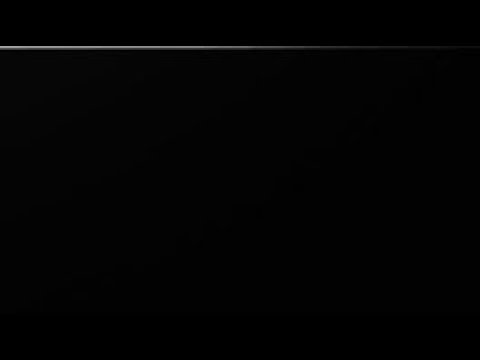

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("a_J5lV4KT3Q", width=600)

# Network Analysis in Computational Social Science

This week, we'll delve deeper into the network of Computational Social Scientists, focusing on advanced network features. If your network is composed of multiple components, concentrate on the giant connected component (GCC) for the exercises below. Utilize the network constructed in [Week 4](https://github.com/lalessan/comsocsci2024/blob/main/lectures/Week4.ipynb).

> __Exercise 1: Mixing Patterns and Assortativity__  
>
> __Part 1: Assortativity Coefficient__ 
> 1. *Calculate the Assortativity Coefficient* for the network based on the country of each node. Implement the calculation using the formula provided during the lecture, also available in [this paper](https://arxiv.org/pdf/cond-mat/0209450.pdf) (equation 2, here for directed networks). **Do not use the NetworkX implementation.**
>
> __Part 2: Configuration model__
> In the following, we are going to assess the significance of the assortativity by comparing the network's assortativity coefficient against that of random networks generated through the configuration model.  
>
> 2. *Implement the configuration model* using the _double edge swap_ algorithm to generate random networks. Ensure each node retains its original degree but with altered connections. Create a function that does that by following these steps:
>   - **a.** Create an exact copy of your original network.
>   - **b.** Select two edges, $e_{1} = (u,v)$ and $e_{2} = (x,y)$, ensuring *u != y* and *v != x*.
>   - **c.** Flip the direction of $e_{1}$ to $e_{1} = (v,u)$ 50% of the time. This ensure that your final results is not biased, in case your edges were sorted (they usually are). 
>   - **d.** Ensure that new edges $e_{1}' = (e_{1}[0],e_{2}[1])$ and $e_{2}' = (e_{2}[0],e_{1}[1])$ do not already exist in the network.
>   - **e.** Remove edges $e_{1}$ and $e_{2}$ and add edges $e_{1}'$ and $e_{2}'$.
>   - **f.** Repeat steps **b** to **e** until you have performed _E*10_ swaps, where E is the total number of edges.
> 3. *Double check that your algorithm works well*, by showing that the degree of nodes in the original network and the new 'randomized' version of the network are the same.
>
>
> __Part 3: Analyzing Assortativity in Random Networks__  
>
> 4. *Generate and analyze at least 100 random networks* using the configuration model. For each, calculate the assortativity with respect to the country and plot the distribution of these values. Compare the results with the assortativity of your original network to determine if connections within the same country are significantly higher than chance.
>
> __Part 4: Assortativity by Degree__
>
> 5. *Calculate degree assortativity* for your network using the formula discussed in the lecture.
> 6. *Compare your network's degree assortativity* against that of 100 random networks generated via the configuration model. Analyze whether your network shows a tendency for high-degree scientists to connect with other high-degree scientists and vice versa. 
>
> __Part 5: Reflection questions__    
> 7. *Assortativity by degree.* Were the results of the degree assortativity in line with your expectations? Why or why not?    
> 8. *Edge flipping.* In the process of implementing the configuration model, you were instructed to flip the edges (e.g., changing *e_1* from (u,v) to (v,u)) 50% of the time. Why do you think this step is included?    
> 9. *Distribution of assortativity in random networks.* Describe the distribution of degree assortativity values you observed for the random 
networks. Was the distribution pattern expected? Discuss how the nature of random network generation (specifically, the configuration model and edge flipping) might influence this distribution and whether it aligns with theoretical expectations.    




> **Exercise 2: Central nodes.** Remember to write your answers in the notebook. 
> * Find the 5 most central scientists according to the closeness centrality. What role do you imagine scientists with high closeness centrality play? 
> * Find the 5 most central scientists according to eigenvector centrality.     
> * Plot the closeness centrality of nodes vs their degree. Is there a correlation between the two? Did you expect that? Why?    
> * Repeat the two points above using eigenvector centrality instead. Do you observe any difference? Why?

# Part 2: Community detection.

We will continue the analysis of our network of Computational Social Scientists.
We will start by learning about community detection with a lecture from my colleague Sune Lehmann.

> **_Video Lecture_**: Communities in networks. 


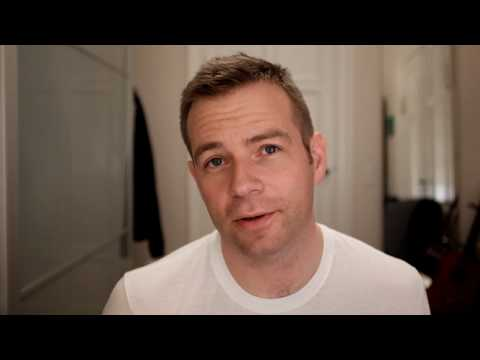

In [7]:
from IPython.display import YouTubeVideo
YouTubeVideo("FSRoqXw28RI",width=800, height=450)

> **_Reading_**: [Chapter 9 of the NS book.](http://networksciencebook.com/chapter/9). You can skip sections 9.3, 9.5 and 9.7. 



> __Exercise 3: Zachary's karate club__: In this exercise, we will work on Zarachy's karate club graph (refer to the Introduction of Chapter 9). The dataset is available in NetworkX, by calling the function [karate_club_graph](https://networkx.org/documentation/stable//auto_examples/graph/plot_karate_club.html) 
>
> 1. Visualize the graph. Set the color of each node based on the club split (the information is stored as a node attribute). My version of the visualization is below.
>
> 2. Write a function to compute the __modularity__ of a graph partitioning (use **equation 9.12** in the book). The function should take a networkX Graph and a partitioning as inputs and return the modularity.
> 3. Explain in your own words the concept of _modularity_. 
> 4. Compute the modularity of the Karate club split partitioning using the function you just wrote. Note: the Karate club split partitioning is avilable as a [node attribute](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.classes.function.get_node_attributes.html), called _"club"_.
> 5. Create $1000$ randomized version of the Karate Club network using the _double edge swap_ algorithm you wrote in the exercise above 5. For each of them, compute the modularity of the "club" split and store it in a list.
> 6. Compute the average and standard deviation of the modularity for the random network.
> 7. Plot the distribution of the "random" modularity. Plot the actual modularity of the club split as a vertical line (use [axvline](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html)). 
> 8. Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to perform a randomization experiment? What is the reason why we preserved the nodes degree?
> 9.  Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities in this graph. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the club split? What does this comparison reveal?
> 10.  Compare the communities found by the Louvain algorithm with the club split partitioning by creating a matrix **_D_** with dimension (2 times _A_), where _A_ is the number of communities found by Louvain. We set entry _D_(_i_,_j_) to be the number of nodes that community _i_ has in common with group split _j_. The matrix **_D_** is what we call a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix). Use the confusion matrix to explain how well the communities you've detected correspond to the club split partitioning.

<img src="https://github.com/lalessan/comsocsci2021/raw/master/files/karate.png" alt="Drawing" style="width: 800px;"/>

> __Exercise 4__: Community detection on the network of Computational Social Scientists. 
>
> * Consider the network of Computational Social Scientists. 
> * Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities. How many communities do you find? What are their sizes? Report the value of modularity found by the algorithm. Is the modularity significantly different than 0? 
> * If you are curious, you can also try the *Infomap* algorithm. Go to [this page]. (https://mapequation.github.io/infomap/python/). It's harder to install, but a better community detection algorithm. You can read about it in [advanced topics 9B](http://networksciencebook.com/chapter/9#advanced-9b).
> * Visualize the network, using netwulf (see Week 5). This time assign each node a different color based on their _community_. Describe the structure you observe.
> * Make sure you save the assignment of authors to communities.
